In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
fig_size = [16, 9]
plt.rcParams['figure.figsize'] = fig_size

## The Perceptron

In [2]:
iris = load_iris()

X = iris.data[:, (2, 3)] # petal length, width
y = (iris.target == 0).astype(np.int) # 1 = Setosa

In [5]:
perceptron_clf = Perceptron(random_state = 1976)
perceptron_clf.fit(X, y)

y_pred = perceptron_clf.predict([[2, 0.5]])
y_pred

array([1])

[0.5, 6.5, 0, 3]

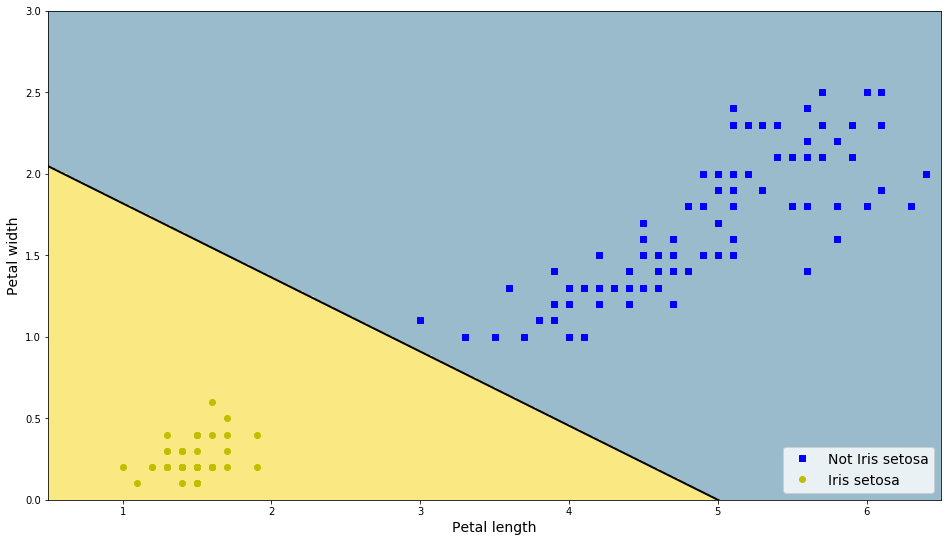

In [6]:
a = -perceptron_clf.coef_[0][0] / perceptron_clf.coef_[0][1] 
b = -perceptron_clf.intercept_ / perceptron_clf.coef_[0][1]

axes = [0.5, 6.5, 0, 3]

x0, x1 = np.meshgrid(np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
                     np.linspace(axes[2], axes[3], 200).reshape(-1, 1),)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = perceptron_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.plot(X[y == 0, 0], X[y == 0, 1], 'bs', label = 'Not Iris setosa')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'yo', label = 'Iris setosa')
plt.plot([axes[0], axes[1]], 
         [a * axes[0] + b, a * axes[1] + b], 
         'k-', 
         linewidth = 2)
custom_cmap = ListedColormap(['#99BBCC', '#FAE982'])

plt.contourf(x0, x1, zz, cmap = custom_cmap, linewidth = 4)
plt.xlabel('Petal length', fontsize = 14)
plt.ylabel('Petal width', fontsize = 14)
plt.legend(loc = 'lower right', fontsize = 14)
plt.axis(axes)

## Training a DNN Using Plain TensorFlow
### Construction Phase

In [8]:
n_inputs = 28 * 28 # MNIST data
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [9]:
X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(tf.int64, shape = (None), name = 'y')

In [10]:
def neuron_layer(X, n_neurons, name, activation = None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        # 'truncated_normal' is normal with the tails cutoff so no extreme
        # values
        init = tf.truncated_normal((n_inputs, n_neurons), stddev = stddev)
        
        W = tf.Variable(init, name = 'weights')
        b = tf.Variable(tf.zeros([n_neurons]), name = 'biases')
        z = tf.matmul(X, W) + b
        
        if activation == 'relu':
            return tf.nn.relu(z)
        else:
            return z

In [11]:
#with tf.name_scope('dnn'):
#    hidden1 = neuron_layer(X, n_hidden1, 'hidden1', activation = 'relu')
#    hidden2 = neuron_layer(
#        hidden1, n_hidden2, 'hidden2', activation = 'relu')
#    logits = neuron_layer(hidden2, n_outputs, 'outputs')

# This can all be streamlined with TF's built in 'fully_connected()'

In [13]:
with tf.name_scope('dnn'):
    # relu is default activation
    hidden1 = fully_connected(X, n_hidden1, scope = 'hidden1')
    hidden2 = fully_connected(hidden1, n_hidden2, scope = 'hidden2')
    logits = fully_connected(
        hidden2, n_outputs, scope = 'outputs', activation_fn = None)

In [14]:
with tf.name_scope('loss'):
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = y, logits = logits)
    loss = tf.reduce_mean(x_entropy, name = 'loss')

Note: 
* `sparse_softmax_cross_entropy_with_logits()` expects labels to be on [0, K - 1]
* `softmax_cross_entropy_with_logits()` is the same, but expects a matrix of one-hot encodings

In [16]:
ETA = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = ETA)
    training_op = optimizer.minimize(loss)

In [17]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Execution Phase

In [20]:
mnist = input_data.read_data_sets('/tmp/data/')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [21]:
n_epochs = 400
batch_size = 50

In [25]:
with tf.Session() as s:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict = { X: X_batch, y: y_batch })
        acc_train = accuracy.eval(feed_dict = { X: X_batch, y: y_batch })
        acc_test = accuracy.eval(feed_dict = { X: mnist.test.images,
                                               y: mnist.test.labels })
        if epoch % 20 == 0:
            print(epoch, 
                  'Train accuracy:', 
                  acc_train, 
                  'Test accuracy:', 
                  acc_test)
    save_path = saver.save(s, './mnist_model.ckpt')

0 Train accuracy: 0.92 Test accuracy: 0.9033
20 Train accuracy: 0.98 Test accuracy: 0.9726
40 Train accuracy: 1.0 Test accuracy: 0.9769
60 Train accuracy: 1.0 Test accuracy: 0.9794
80 Train accuracy: 1.0 Test accuracy: 0.9796
100 Train accuracy: 1.0 Test accuracy: 0.9797
120 Train accuracy: 1.0 Test accuracy: 0.9789
140 Train accuracy: 1.0 Test accuracy: 0.9791
160 Train accuracy: 1.0 Test accuracy: 0.9793
180 Train accuracy: 1.0 Test accuracy: 0.9797
200 Train accuracy: 1.0 Test accuracy: 0.9792
220 Train accuracy: 1.0 Test accuracy: 0.9796
240 Train accuracy: 1.0 Test accuracy: 0.9798
260 Train accuracy: 1.0 Test accuracy: 0.9799
280 Train accuracy: 1.0 Test accuracy: 0.9795
300 Train accuracy: 1.0 Test accuracy: 0.9798
320 Train accuracy: 1.0 Test accuracy: 0.9798
340 Train accuracy: 1.0 Test accuracy: 0.98
360 Train accuracy: 1.0 Test accuracy: 0.98
380 Train accuracy: 1.0 Test accuracy: 0.9803


## Using the Neural Network for Predictions

In [27]:
!cat ../book*

https://github.com/ageron/handson-ml


In [30]:
with tf.Session() as s:
    saver.restore(s, './mnist_model.ckpt')
    X_new_scaled = mnist.test.images[21:40]
    Z = logits.eval(feed_dict = { X: X_new_scaled })
    
    print(np.argmax(Z, axis = 1))
    print(mnist.test.labels[21:40])

INFO:tensorflow:Restoring parameters from ./mnist_model.ckpt
[6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1]
[6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1]
